# LSTM model

## Architecture

Many-to-many

## DataSet implementation

- Index is ticker based (create dictionary)
- Analysis on padding



### Configuration parameters

In [93]:
TRANSFORMED_DATA_FN = "../data/transformed/data.csv" # Data
TRANSFORMED_META_FN = "../data/transformed/data.json" # Metadata

MAX_SEQ_LENGTH = 25
MIN_SEQ_LENGTH = 10

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import seaborn as sns

sns.set_style("whitegrid")

### Load data

In [95]:
df_1 = pd.read_csv(TRANSFORMED_DATA_FN)

In [96]:
# Convert datetimes

for col in ('calendardate', 'datekey', 'reportperiod', 'lastupdated'):
    df_1[col] = pd.to_datetime(df_1[col])

In [97]:
df_2 = df_1.sort_values(by=['ticker', 'datekey'])

In [98]:
with open(TRANSFORMED_META_FN, 'r') as fp:
    metadata = json.load(fp)
    
features = metadata['features'].split(",")
target = metadata['target']

In [99]:
seq_lengths = df_2.groupby('ticker').count()['datekey'].values


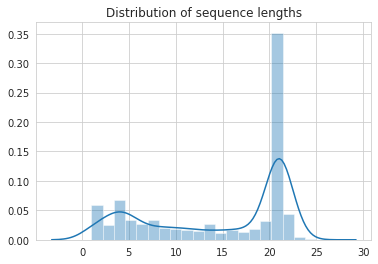

In [100]:
sns.distplot(seq_lengths, bins = 20);
plt.title("Distribution of sequence lengths");

In [101]:
max(seq_lengths)

25

In [102]:
print("Maximum sequence length: ", max(seq_lengths))

Maximum sequence length:  25


In [159]:
def get_padded_features(sorted_df, ticker, features, target, n_pad):
    """ Return padded features and target
    
    Arguments
    ---------
    
    sorted_df : Pandas dataframe
        Dataframe with indicators, sorted by ticker and datekey        
    ticker : str
        Ticker name
    features : list
        Feature names        
    target : str
        Target name
    pad : int
        Pad length
    
    Returns
    -------
    padded_features : ndarray with shape (n_pad, n_features)
    target : ndarray with shape (n_pad,1)
    
    """
    
    n_features = len(features)
    
    ticker_data = sorted_df.loc[sorted_df['ticker'] == ticker, :]
    
    ticker_features = ticker_data.loc[:, features]
    ticker_target = ticker_data.loc[:, target]
   
    out_features = np.zeros((n_pad, n_features))
    out_target = np.zeros((n_pad, 1))
    
    out_features[0:len(ticker_features)] = ticker_features.values
    out_target[0:len(ticker_features)] = ticker_target.values.reshape(-1,1)
    
    return out_features, out_target

In [143]:
feat_array, target_array = get_padded_features(df_2, ticker='GEN', features = features, target = target, n_pad = MAX_SEQ_LENGTH)

In [144]:
feat_array.shape, target_array.shape

((25, 26), (25, 1))

### Prepare data

In [145]:
from torch.utils.data import Dataset, DataLoader

In [146]:
# Create unique ticker list and shuffle

all_tickers = df_2['ticker'].unique()
np.random.shuffle(all_tickers)

In [147]:
len(df_2['ticker'].unique())

5853

In [152]:
class TickersIndicatorsDataset(Dataset):
    """
    Tickers Indicators Dataset
    
    """
    def __init__(self, indicators_df, feature_names, target_name, n_pad):
        
        self.df = indicators_df.sort_values(by=['ticker', 'datekey'])
        self.target = target_name
        self.features = feature_names
        self.ticker_list = self.df['ticker'].unique()
        self.n_pad = n_pad
        
    def __len__(self):
        return len(self.ticker_list)
    
    def __getitem__(self, idx):
        ticker = self.ticker_list[idx]
        X, y = get_padded_features(self.df, ticker=ticker, features = self.features, target = self.target, n_pad = self.n_pad)
        return X,y

In [153]:
td = TickersIndicatorsDataset(df_2, all_tickers, features, target, MAX_SEQ_LENGTH )

In [158]:
len(td)

5853

### Pre-processing

Scaling and imputation

In [206]:

from sklearn import preprocessing
from sklearn.preprocessing import Imputer

In [207]:
test_ratio = 0.8

test_idx = int(len(all_tickers)*test_ratio)

In [208]:
train_tickers = all_tickers[:test_idx]
test_tickers = all_tickers[test_idx:]

In [209]:
df_train = df_2[df_2['ticker'].isin(train_tickers)][features]
df_test = df_2[df_2['ticker'].isin(test_tickers)][features]

In [210]:
# Imputation

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(df_train)

df_train_imp = pd.DataFrame(imputer.transform(df_train))
df_train_imp.columns = df_train.columns
df_train_imp.index = df_train.index

df_test_imp = pd.DataFrame(imputer.transform(df_test))
df_test_imp.columns = df_test.columns
df_test_imp.index = df_test.index

In [211]:
# Scaler

scaler = preprocessing.StandardScaler().fit(df_train_imp)

df_train_imp = pd.DataFrame(scaler.transform(df_train_imp))
df_train_imp.columns = df_train_imp.columns
df_train_imp.index = df_train_imp.index


df_test_imp = pd.DataFrame(scaler.transform(df_test_imp))
df_test_imp.columns = df_test_imp.columns
df_test_imp.index = df_test_imp.index

In [212]:
df_train_imp.describe()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,...,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04,6.842900e+04
mean,-2.533088e-17,-3.719162e-17,-1.358063e-18,-9.689527e-17,-3.291140e-17,-2.445395e-17,-1.499807e-16,-1.759709e-17,5.413364e-18,2.519633e-17,...,-3.954913e-18,3.186084e-15,2.828784e-18,1.463309e-17,-1.548786e-16,1.101012e-17,1.497740e-17,-4.787725e-16,7.134753e-18,1.347931e-15
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.796212e+01,-3.285323e-02,-4.112173e-02,-2.227163e-01,-3.753221e+01,-2.542331e+02,-7.250845e-03,-8.394614e+00,-2.586368e+02,-2.302151e+02,...,-1.449052e+02,-1.407114e+02,-5.766320e-02,-3.452951e-02,-7.701252e+01,-1.132936e+02,-1.438808e+02,-2.914078e-02,-7.546697e-03,-2.480739e+00
25%,-4.422694e-03,-2.950706e-02,-2.871455e-02,-2.163760e-01,-9.781616e-02,-1.953352e-04,-7.174306e-03,-3.289604e-02,4.874456e-04,-2.137017e-03,...,3.732821e-02,-1.132739e-01,-2.932452e-02,-1.608424e-02,2.240731e-02,-6.715649e-03,3.784058e-02,-2.914078e-02,-7.545391e-03,-7.975918e-01
50%,-4.422688e-03,-2.873547e-02,-1.823495e-02,-1.948123e-01,2.878401e-03,4.834451e-03,-7.171579e-03,-3.209679e-02,3.796015e-03,1.520966e-03,...,3.802403e-02,0.000000e+00,-2.872056e-02,-1.608336e-02,1.337234e-01,-5.902031e-03,3.858985e-02,-2.914078e-02,-7.543836e-03,4.188455e-02
75%,-4.422681e-03,-2.532646e-02,0.000000e+00,-1.123089e-01,7.159541e-02,8.195414e-03,-7.163544e-03,-3.031614e-02,5.639659e-03,4.053416e-03,...,3.883076e-02,1.622304e-01,-2.628507e-02,-1.608281e-02,1.935558e-01,-3.590614e-03,3.920424e-02,-5.541413e-03,-7.540753e-03,7.864544e-01
max,2.524381e+02,1.138286e+02,1.644662e+02,3.094016e+01,4.587229e+01,2.339506e+01,2.046693e+02,1.508173e+02,1.654687e+01,7.405064e+01,...,1.641346e+01,1.116306e+01,9.295070e+01,9.580551e+01,1.172869e+01,9.423931e+01,1.638943e+01,2.264067e+02,1.706178e+02,2.051699e+00


## LSTM Model

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [162]:
class Model(nn.Module):
    
    def __init__(self, feature_size, n_activation = 20):
        super(Model, self).__init__()
        
        self.n_activation = n_activation
        
        # LSTM parameters - input feature size X, number of units in hidden layer.
        
        self.lstm = nn.LSTM(feature_size, n_activation)        
        self.out = nn.Linear(n_activation, 1)
    
    def forward(self, x):
        
        # x has dimension of [batch_size, sequence size]       
        
        # Here h_lstm contains hidden activations from all sequences, dimension: [batch_size, seq_size, n_activation]
        h_lstm, (h_n, c_n) = self.lstm(h_embedding)
        out = F.sigmoid(self.out(h_lstm))
        return out